In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone,UNetBlockStyleMLP_backbone_NoFirstNorm
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.img_patch_stats_analysis_lib import *
from core.gaussian_mixture_lib import GaussianMixture_torch
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [3]:
def delta_GMM_score(Xt, train_Xmat, sigma, return_weights=False):
    # get squared distance matrix
    sqdist = torch.cdist(Xt, train_Xmat, p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    score = (torch.matmul(weights, train_Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_denoiser(Xt, train_Xmat, sigma):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    denoised = torch.matmul(weights, train_Xmat)
    return denoised

In [4]:
class EDMDeltaGMMScoreLoss:
    def __init__(self, train_Xmat, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.train_Xmat = train_Xmat
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        # loss = weight * ((D_yn - X) ** 2)
        loss = weight * ((D_yn - D_gmm) ** 2)
        return loss

In [5]:
def visualize_trajs(x_traj, t_steps, pnts, title): # x0hat_traj, samples, 
    scaling = 1 / (t_steps ** 2 + 1).sqrt()
    scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
    plt.figure(figsize=(8, 8))
    plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
            scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
    plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
    plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
    plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
    plt.axis("equal")
    plt.title(title)
    plt.legend()
    return plt.gcf()

### GMM

In [6]:
from core.gaussian_mixture_lib import GaussianMixture_torch

In [8]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_cmp_debug")
os.makedirs(savedir, exist_ok=True)

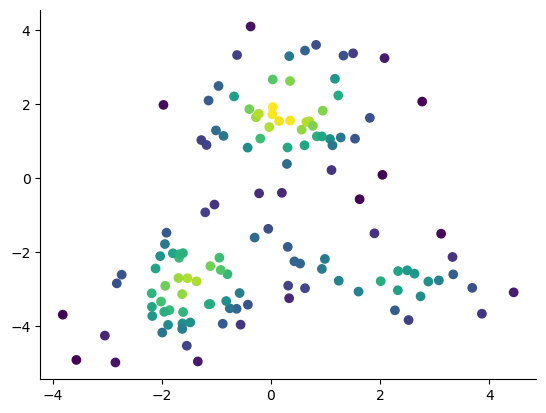

In [9]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
torch.manual_seed(42)
pnts, _, _ = gmm.sample(128)
density = gmm.pdf(pnts)
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis")
plt.show()

In [30]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_cmp_GMM_data_wellnormed_nofirstnorm_fixnormed")
model_precd_dsm2 = torch.load(join(savedir, "model_precd_dsm_2.pth"))
model_precd_esm2 = torch.load(join(savedir, "model_precd_esm_2.pth"))

/tmp/ipykernel_495849/4046664201.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_precd_dsm2 = torch.load(join(savedir, "model_precd_dsm_2.pth"))
/tmp/ipykernel_495

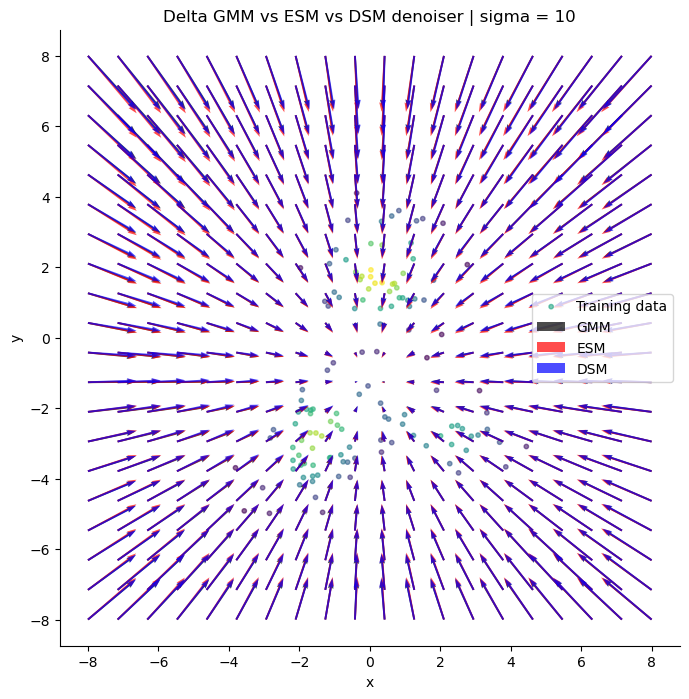

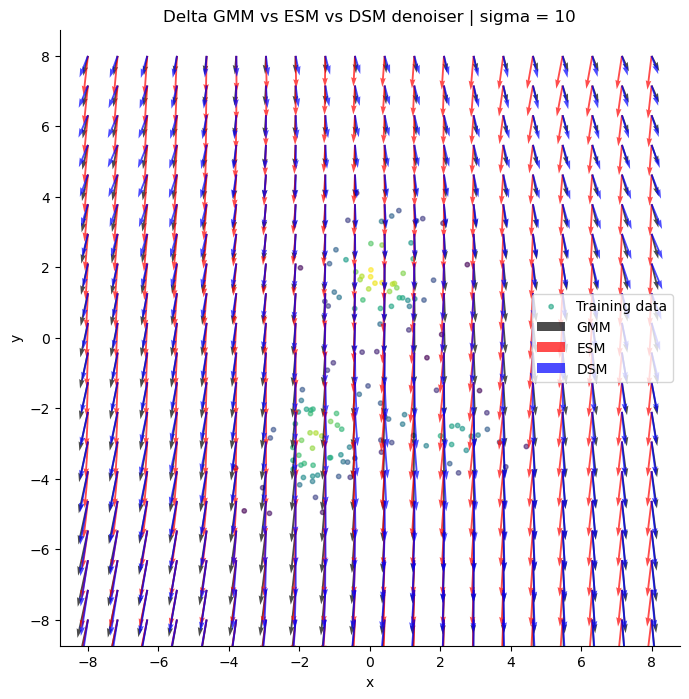

In [55]:
nticks = 20
# Create probe mesh grid
x_range = torch.linspace(-8, 8, nticks)
y_range = torch.linspace(-8, 8, nticks)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
probe_pnts = torch.stack([X.flatten(), Y.flatten()], dim=1)
# Calculate delta GMM score at probe points
sigma = 10
denoised_gmm = delta_GMM_denoiser(probe_pnts, pnts, sigma=sigma)
with torch.no_grad():
    denoised_esm = model_precd_esm2(probe_pnts.cuda(), torch.ones(probe_pnts.shape[0], 1).cuda() * sigma).cpu()
    denoised_dsm = model_precd_dsm2(probe_pnts.cuda(), torch.ones(probe_pnts.shape[0], 1).cuda() * sigma).cpu()
# Reshape scores for plotting
denoised_x_gmm = denoised_gmm[:, 0].reshape(nticks, nticks)
denoised_y_gmm = denoised_gmm[:, 1].reshape(nticks, nticks)
denoised_x_esm = denoised_esm[:, 0].reshape(nticks, nticks)
denoised_y_esm = denoised_esm[:, 1].reshape(nticks, nticks)
denoised_x_dsm = denoised_dsm[:, 0].reshape(nticks, nticks)
denoised_y_dsm = denoised_dsm[:, 1].reshape(nticks, nticks)
# Plot as vector field
plt.figure(figsize=(8, 8))
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, 
            cmap="viridis", alpha=0.6, s=10,
            label="Training data")
plt.quiver(X, Y, denoised_x_gmm - X, denoised_y_gmm - Y, alpha=0.7, scale=100, color="k", label="GMM")
plt.quiver(X, Y, denoised_x_esm - X, denoised_y_esm - Y, alpha=0.7, scale=100, color="r", label="ESM")
plt.quiver(X, Y, denoised_x_dsm - X, denoised_y_dsm - Y, alpha=0.7, scale=100, color="b", label="DSM")
plt.title(f"Delta GMM vs ESM vs DSM denoiser | sigma = {sigma}")
plt.xlabel("x")
plt.ylabel("y") 
plt.legend()
plt.axis("equal")
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, 
            cmap="viridis", alpha=0.6, s=10,
            label="Training data")
plt.quiver(X, Y, denoised_x_gmm, denoised_y_gmm, alpha=0.7, scale=20, color="k", label="GMM")
plt.quiver(X, Y, denoised_x_esm, denoised_y_esm, alpha=0.7, scale=20, color="r", label="ESM")
plt.quiver(X, Y, denoised_x_dsm, denoised_y_dsm, alpha=0.7, scale=20, color="b", label="DSM")
plt.title(f"Delta GMM vs ESM vs DSM denoiser | sigma = {sigma}")
plt.xlabel("x")
plt.ylabel("y") 
plt.legend()
plt.axis("equal")
plt.show()

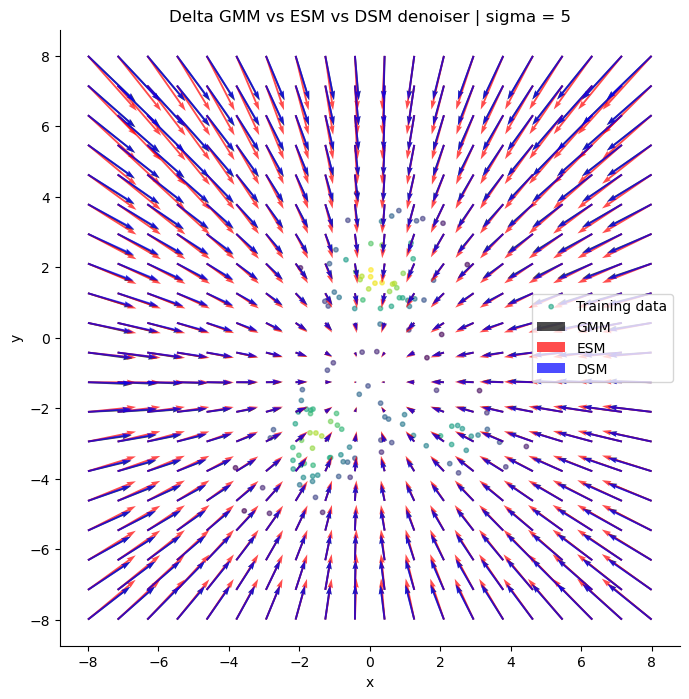

In [50]:
nticks = 20
# Create probe mesh grid
x_range = torch.linspace(-8, 8, nticks)
y_range = torch.linspace(-8, 8, nticks)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
probe_pnts = torch.stack([X.flatten(), Y.flatten()], dim=1)
# Calculate delta GMM score at probe points
sigma = 5
denoised_gmm = delta_GMM_denoiser(probe_pnts, pnts, sigma=sigma)
with torch.no_grad():
    denoised_esm = model_precd_esm2(probe_pnts.cuda(), torch.ones(probe_pnts.shape[0], 1).cuda() * sigma).cpu()
    denoised_dsm = model_precd_dsm2(probe_pnts.cuda(), torch.ones(probe_pnts.shape[0], 1).cuda() * sigma).cpu()
# Reshape scores for plotting
denoised_x_gmm = denoised_gmm[:, 0].reshape(nticks, nticks)
denoised_y_gmm = denoised_gmm[:, 1].reshape(nticks, nticks)
denoised_x_esm = denoised_esm[:, 0].reshape(nticks, nticks)
denoised_y_esm = denoised_esm[:, 1].reshape(nticks, nticks)
denoised_x_dsm = denoised_dsm[:, 0].reshape(nticks, nticks)
denoised_y_dsm = denoised_dsm[:, 1].reshape(nticks, nticks)
# Plot as vector field
plt.figure(figsize=(8, 8))
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, 
            cmap="viridis", alpha=0.6, s=10,
            label="Training data")
plt.quiver(X, Y, denoised_x_gmm - X, denoised_y_gmm - Y, alpha=0.7, scale=100, color="k", label="GMM")
plt.quiver(X, Y, denoised_x_esm - X, denoised_y_esm - Y, alpha=0.7, scale=100, color="r", label="ESM")
plt.quiver(X, Y, denoised_x_dsm - X, denoised_y_dsm - Y, alpha=0.7, scale=100, color="b", label="DSM")
plt.title(f"Delta GMM vs ESM vs DSM denoiser | sigma = {sigma}")
plt.xlabel("x")
plt.ylabel("y") 
plt.legend()
plt.axis("equal")
plt.show()

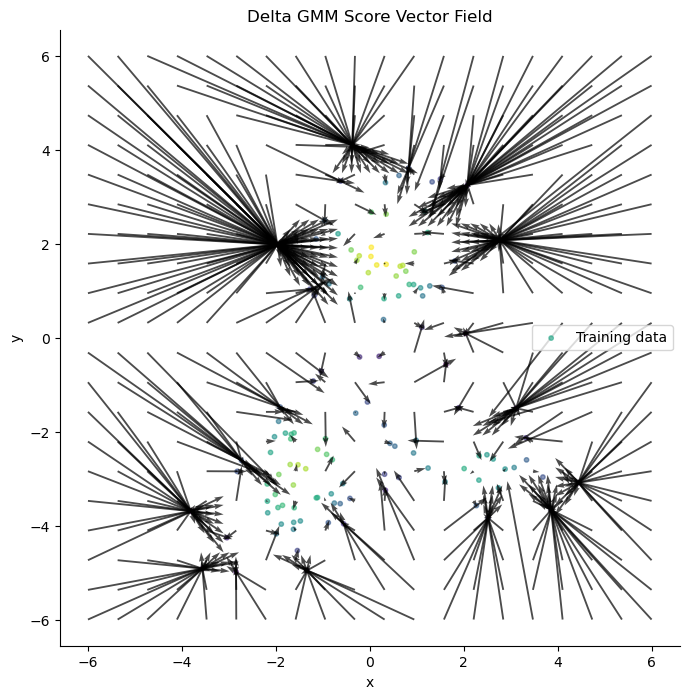

In [29]:
# Create probe mesh grid
x_range = torch.linspace(-6, 6, 20)
y_range = torch.linspace(-6, 6, 20)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
probe_pnts = torch.stack([X.flatten(), Y.flatten()], dim=1)
# Calculate delta GMM score at probe points
sigma = 0.1
scores = delta_GMM_score(probe_pnts, pnts, sigma=sigma) * sigma
# Reshape scores for plotting
score_x = scores[:, 0].reshape(20, 20)
score_y = scores[:, 1].reshape(20, 20)
# Plot as vector field
plt.figure(figsize=(8, 8))
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, 
            cmap="viridis", alpha=0.6, s=10,
            label="Training data")
plt.quiver(X, Y, score_x, score_y, alpha=0.7, scale=100,)
plt.title("Delta GMM Score Vector Field")
plt.xlabel("x")
plt.ylabel("y") 
plt.legend()
plt.axis("equal")
plt.show()

### Try optimization with one noise scale

In [86]:
class EDMDeltaGMMScoreLossSingleNoise:
    def __init__(self, train_Xmat, sigma_train=2, sigma_data=0.5):
        self.train_Xmat = train_Xmat
        self.sigma_train = sigma_train
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        # rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        # sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        sigma = self.sigma_train * torch.ones([X[:, 0].shape[0],]+[1, ] * (X.ndim - 1), device=X.device)
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        # bug!!!        
        # D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        D_gmm = delta_GMM_denoiser(X + n, self.train_Xmat, sigma) # Fixed July27
        # loss = weight * ((D_yn - X) ** 2)
        loss = weight * ((D_yn - D_gmm) ** 2)
        return loss


class EDMLossSingleNoise:
    def __init__(self, sigma_train=2, sigma_data=0.5):
        self.sigma_train = sigma_train
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        # rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        # sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        sigma = self.sigma_train * torch.ones([X[:, 0].shape[0],]+[1, ] * (X.ndim - 1), device=X.device)
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        # D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        # loss = weight * ((D_yn - D_gmm) ** 2)
        loss = weight * ((D_yn - X) ** 2)
        return loss

#### Before bug fixing

In [66]:
device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
train_noise_sigma = 2
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm_SNS = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_esm_SNS = EDMDeltaGMMScoreLossSingleNoise(pnts.to(device), sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_esm_SNS, loss_traj_esm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_esm_SNS, 
    loss_fn=loss_fn_esm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)


model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm_SNS = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_dsm_SNS = EDMLossSingleNoise(sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_dsm_SNS, loss_traj_dsm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_dsm_SNS, 
    loss_fn=loss_fn_dsm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 0.899


  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 1.291


In [69]:
pnts.mean(dim=0)

tensor([-0.0376, -1.1034])

In [ ]:
with torch.no_grad():
    loss = loss_fn_esm_SNS(model_precd_esm_SNS, pnts.repeat(30, 1).cuda())
    print("ESM loss for ESM trained network")
    print(loss.mean())
    print(loss)
    
    
with torch.no_grad():
    loss = loss_fn_esm_SNS(model_precd_dsm_SNS, pnts.repeat(30, 1).cuda())
    print("ESM loss for DSM trained network")
    print(loss.mean())
    print(loss)
    

ESM loss for ESM trained network
tensor(0.3868, device='cuda:0')
tensor([[0.4553, 0.5013],
        [0.0958, 0.0685],
        [0.1631, 0.1018],
        ...,
        [0.0280, 0.0080],
        [0.1708, 0.0916],
        [0.0241, 0.1920]], device='cuda:0')
ESM loss for DSM trained network
tensor(0.5195, device='cuda:0')
tensor([[0.5173, 0.3727],
        [0.3018, 0.1582],
        [0.8027, 0.0132],
        ...,
        [0.0116, 0.1006],
        [0.8299, 0.2312],
        [0.3696, 0.0555]], device='cuda:0')


In [70]:
device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
train_noise_sigma = 5
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm_SNS = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_esm_SNS = EDMDeltaGMMScoreLossSingleNoise(pnts.to(device), sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_esm_SNS, loss_traj_esm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_esm_SNS, 
    loss_fn=loss_fn_esm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)


model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm_SNS = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_dsm_SNS = EDMLossSingleNoise(sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_dsm_SNS, loss_traj_dsm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_dsm_SNS, 
    loss_fn=loss_fn_dsm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 0.388


  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 1.137


In [ ]:
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
num_reps = 20
stats_col = []
for sigma in np.logspace(np.log10(0.002), np.log10(100.0), 50):
    # Create multiple noised versions for better evaluation
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm_SNS(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm_SNS(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])#sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2)
    mmse_dsm_x0 = torch.mean((denoised_dsm - pnts_rep) ** 2)
    stats_col.append({
        "sigma": sigma,
        "mmse_esm": mmse_esm.item(),
        "mmse_dsm": mmse_dsm.item(),
        "mmse_gmm_x0": mmse_gmm_x0.item(),
        "mmse_dsm_x0": mmse_dsm_x0.item(),
        })
stats_df = pd.DataFrame(stats_col)
stats_df.to_csv(join(savedir, "stats_col.csv"), index=False)

Text(0, 0.5, 'MMSE to GMM denoiser')

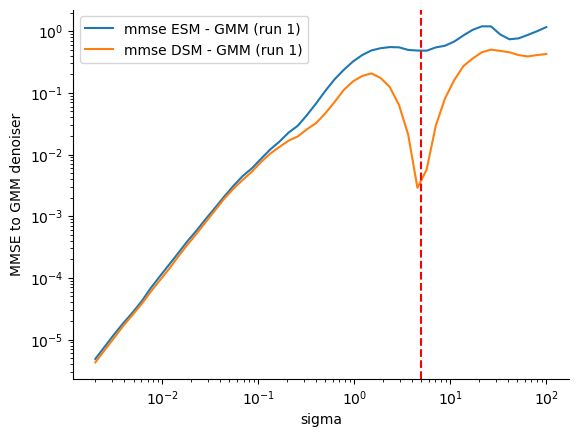

In [ ]:
stats_df.plot(x="sigma", y=["mmse_esm",  "mmse_dsm", ], kind="line")
plt.axvline(x=train_noise_sigma, color="red", linestyle="--", label="Training noise sigma")
plt.legend(["mmse ESM - GMM (run 1)", "mmse DSM - GMM (run 1)",])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MMSE to GMM denoiser")

#### After bug fixing

In [87]:
device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
train_noise_sigma = 5
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm_SNS = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_esm_SNS = EDMDeltaGMMScoreLossSingleNoise(pnts.to(device), sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_esm_SNS, loss_traj_esm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_esm_SNS, 
    loss_fn=loss_fn_esm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)


model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm_SNS = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
loss_fn_dsm_SNS = EDMLossSingleNoise(sigma_train=train_noise_sigma, sigma_data=sigma_data)
model_precd_dsm_SNS, loss_traj_dsm_SNS = train_score_model_custom_loss(
    X_train_tsr=pnts, score_model_td=model_precd_dsm_SNS, 
    loss_fn=loss_fn_dsm_SNS, nepochs=10000, batch_size=2048, lr=1E-4,
    device=device)

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 0.722


  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 1.539


In [89]:
print(f"Sigma train = {train_noise_sigma}")
with torch.no_grad():
    loss = loss_fn_esm_SNS(model_precd_esm_SNS, pnts.repeat(30, 1).cuda())
    print("ESM loss for ESM trained network")
    print(loss.mean())
    print(loss)
    
with torch.no_grad():
    loss = loss_fn_esm_SNS(model_precd_dsm_SNS, pnts.repeat(30, 1).cuda())
    print("ESM loss for DSM trained network")
    print(loss.mean())
    print(loss)

print(f"Sigma train = {train_noise_sigma}")
with torch.no_grad():
    loss = loss_fn_dsm_SNS(model_precd_esm_SNS, pnts.repeat(30, 1).cuda())
    print("DSM loss for ESM trained network")
    print(loss.mean())
    print(loss)
    
with torch.no_grad():
    loss = loss_fn_dsm_SNS(model_precd_dsm_SNS, pnts.repeat(30, 1).cuda())
    print("DSM loss for DSM trained network")
    print(loss.mean())
    print(loss)

Sigma train = 5
ESM loss for ESM trained network
tensor(4.8438e-07, device='cuda:0')
tensor([[9.5996e-09, 4.5583e-07],
        [3.2729e-07, 1.4976e-08],
        [2.9945e-08, 1.2584e-07],
        ...,
        [7.0508e-09, 9.3341e-07],
        [1.2732e-07, 1.8916e-09],
        [2.6160e-08, 1.2710e-08]], device='cuda:0')
ESM loss for DSM trained network
tensor(0.0007, device='cuda:0')
tensor([[2.4030e-04, 1.2666e-03],
        [3.5673e-04, 8.1361e-05],
        [4.4301e-04, 3.0057e-04],
        ...,
        [2.5275e-04, 3.7629e-05],
        [1.1675e-05, 9.0283e-08],
        [3.8905e-04, 3.2486e-06]], device='cuda:0')
Sigma train = 5
DSM loss for ESM trained network
tensor(0.9364, device='cuda:0')
tensor([[0.3362, 0.0572],
        [1.0390, 1.3695],
        [2.2008, 1.5813],
        ...,
        [0.2284, 0.2684],
        [0.2927, 0.3051],
        [0.2621, 2.8828]], device='cuda:0')
DSM loss for DSM trained network
tensor(0.9173, device='cuda:0')
tensor([[1.3840e-01, 1.9903e-02],
        [8.33

In [94]:
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
num_reps = 20
stats_col = []
# for sigma in np.logspace(np.log10(0.002), np.log10(100.0), 50):
for sigma in sorted([5.0] + list(np.logspace(np.log10(0.002), np.log10(100.0), 50))):
    # Create multiple noised versions for better evaluation
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm_SNS(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm_SNS(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])#sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2)
    mmse_dsm_x0 = torch.mean((denoised_dsm - pnts_rep) ** 2)
    stats_col.append({
        "sigma": sigma,
        "mmse_esm": mmse_esm.item(),
        "mmse_dsm": mmse_dsm.item(),
        "mmse_gmm_x0": mmse_gmm_x0.item(),
        "mmse_dsm_x0": mmse_dsm_x0.item(),
        })
stats_df = pd.DataFrame(stats_col)
stats_df.to_csv(join(savedir, "stats_col.csv"), index=False)

Text(0, 0.5, 'MMSE to GMM denoiser')

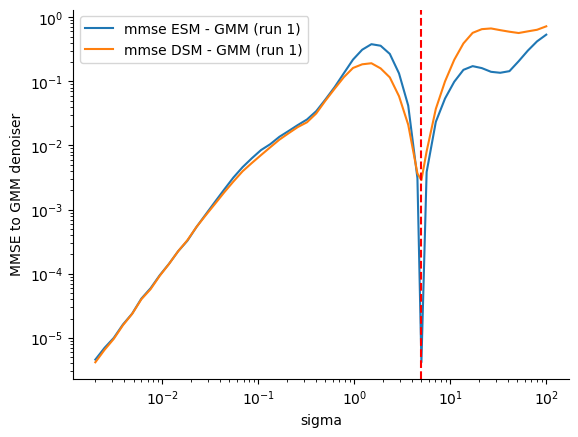

In [95]:
stats_df.plot(x="sigma", y=["mmse_esm",  "mmse_dsm", ], kind="line")
plt.axvline(x=train_noise_sigma, color="red", linestyle="--", label="Training noise sigma")
plt.legend(["mmse ESM - GMM (run 1)", "mmse DSM - GMM (run 1)",])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MMSE to GMM denoiser")

In [ ]:
sigma_data = pnts.std().item()
torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [*range(0, 50000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"Point cloud dataset {pnts.shape[0]} samples, {ndim} features")
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm, join(savedir, "loss_traj_esm.pth"))
torch.save(sample_store, join(savedir, "sample_store_esm.pth"))
torch.save(model_precd_esm, join(savedir, "model_precd_esm.pth"))

sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

model_esm2 = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm2 = EDMPrecondWrapper(model_esm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_esm2, loss_traj_esm2 = train_score_model_custom_loss(pnts, model_precd_esm2, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm2, join(savedir, "loss_traj_esm_2.pth"))
torch.save(sample_store, join(savedir, "sample_store_esm_2.pth"))
torch.save(model_precd_esm2, join(savedir, "model_precd_esm_2.pth"))



sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, "loss_traj_dsm.pth"))
torch.save(sample_store, join(savedir, "sample_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))



sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm2 = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm2 = EDMPrecondWrapper(model_dsm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm2, loss_traj_dsm2 = train_score_model_custom_loss(pnts, model_precd_dsm2, edm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm2, join(savedir, "loss_traj_dsm_2.pth"))
torch.save(sample_store, join(savedir, "sample_store_dsm_2.pth"))
torch.save(model_precd_dsm2, join(savedir, "model_precd_dsm_2.pth"))


MNIST dataset 128 samples, 2 features


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.409


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.306


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.264


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.268
